<a href="https://colab.research.google.com/github/AnantShankhdhar/Flipkart_Category_Prediction/blob/master/LSTM_no_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flipkart category Classification

In this note we make an attempt to build a classifer model to distinguish different product categories on the basis of the product description. <br>
Presently Deep learning based models are delivering the best performance in case of Natural language Processing.<br>
In this notebook, I build a deep learning based model using Long Short Term Memory Networks.

## Import Libraries 

In [ ]:
import gensim.models.keyedvectors as word2vec #need to use due to depreceated model
from nltk.tokenize import RegexpTokenizer
! pip install keras-self-attention
import keras
from keras_self_attention import SeqSelfAttention
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve,  roc_auc_score, classification_report


import logging


## DataSet 
Loading our dataset, and checking out the label distribution of our dataset 

[Errno 2] No such file or directory: 'drive/MyDrive/MIDAS_task'
/content/drive/MyDrive/MIDAS_task
0     6197
16    3531
2     1227
13    1099
9     1012
8      929
6      710
11     699
18     647
20     578
14     530
12     483
10     391
27     342
15     330
4      313
7      265
1      180
5      166
21      82
24      81
22      43
17      40
23      35
3       30
19      24
25      19
26      15
Name: label, dtype: int64
{0: 6197, 16: 3531, 2: 1227, 13: 1099, 9: 1012, 8: 929, 6: 710, 11: 699, 18: 647, 20: 578, 14: 530, 12: 483, 10: 391, 27: 342, 15: 330, 4: 313, 7: 265, 1: 180, 5: 166, 21: 82, 24: 81, 22: 43, 17: 40, 23: 35, 3: 30, 19: 24, 25: 19, 26: 15}


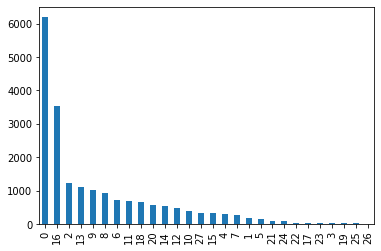

In [ ]:
%cd drive/MyDrive/MIDAS_task
np.random.seed(42)
df = pd.read_csv('outfinal1.csv') 
df.head()
weight_list = dict()
descriptions = df['description']
labels = df['label']
labels_count = labels.value_counts()
labels_count.plot(kind="bar")
print(labels.value_counts())
for index,value in labels_count.items():
    weight_list[index] = value
print(weight_list)

## Tokenizing 

In [ ]:
description_split = []
tkr = RegexpTokenizer('[a-zA-Z@]+')
for i, line in enumerate(descriptions):
    #print(line)
    description = str(line)
    description = tkr.tokenize(str(description))
    description_split.append(description)

print(description_split[1])

['fabhomedecor', 'fabric', 'double', 'sofa', 'bed', 'finish', 'color', 'leatherette', 'black', 'mechanism', 'type', 'pull', 'price', 'rs', 'fine', 'deep', 'seating', 'experience', 'save', 'space', 'new', 'click', 'clack', 'sofa', 'bed', 'easy', 'fold', 'vice', 'versa', 'simple', 'click', 'clack', 'mechanism', 'chrome', 'leg', 'mango', 'wood', 'frame', 'long', 'term', 'durability', 'double', 'cushioned', 'sofa', 'bed', 'provide', 'extra', 'softness', 'make', 'fine', 'seating', 'experience', 'double', 'bed', 'easily', 'sleep', 'twospecification', 'fabhomedecor', 'fabric', 'double', 'sofa', 'bed', 'finish', 'color', 'leatherette', 'black', 'mechanism', 'type', 'pull', 'installation', 'demo', 'installation', 'demo', 'detail', 'installation', 'demo', 'product', 'do', 'free', 'cost', 'part', 'purchase', 'service', 'partner', 'visit', 'location', 'within', 'business', 'hour', 'delivery', 'product', 'box', 'sofa', 'bed', 'general', 'brand', 'fabhomedecor', 'mattress', 'include', 'delivery', 'c

## Vectorization 
Since we know that Deep Learning models can only take numbers, so we need get a numerical representation of the words, this process is called vectorization. <br>
One can train their own vectors from their dataset, but because we don't have very vast amount of data, I am going for using pretrained word2vec vectors which has more than 3 million word vectors. 

## Building the Model 
Here I am designing a model which used word2vec for embedding layer, and LSTM layer because text can be represented as a time series, and LSTM workes best in modeling a time seroies. <br>
Finally we have the Fully Connected Layer, which is usef for classification into categories.


In [ ]:
w2vModel = word2vec.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit=100000) 
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(description_split)
X = tokenizer.texts_to_sequences(description_split)

MAX_LENGTH = 300

#add padding
X = pad_sequences(X, maxlen=MAX_LENGTH) 

print(X.shape)

#create a embedding layer using Google pre triained word2vec (50000 words)
embedding_layer = Embedding(input_dim=w2vModel.syn0.shape[0], output_dim=w2vModel.syn0.shape[1], weights=[w2vModel.syn0], input_length=X.shape[1])

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(units=300))
model.add(Dense(28, activation='softmax'))
model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

(19998, 300)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 300, 300)          30000000  
_________________________________________________________________
lstm_14 (LSTM)               (None, 300)               721200    
_________________________________________________________________
dense_12 (Dense)             (None, 28)                8428      
Total params: 30,729,628
Trainable params: 30,729,628
Non-trainable params: 0
_________________________________________________________________
None


## Train-Test-Validation Spllit 

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, labels, test_size= 0.1, random_state = 24)
X_val, X_test, Y_val, Y_test = train_test_split(X_test,Y_test,test_size = 0.5, random_state = 24)

X_val.shape

(1000, 300)

## Training the model


In [ ]:
batch_size = 32
checkpoint_filepath = 'model_LSTM.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model.fit(X_train, Y_train, epochs=10, verbose=1, batch_size=batch_size,callbacks = [model_checkpoint_callback],validation_data = (X_val,Y_val))

Epoch 1/10
563/563 [==============================] - 171s 302ms/step - loss: 1.4158 - accuracy: 0.6278 - val_loss: 0.5287 - val_accuracy: 0.8570
Epoch 2/10
563/563 [==============================] - 167s 297ms/step - loss: 0.3585 - accuracy: 0.9037 - val_loss: 0.2834 - val_accuracy: 0.9370
Epoch 3/10
563/563 [==============================] - 165s 293ms/step - loss: 0.1960 - accuracy: 0.9463 - val_loss: 0.3144 - val_accuracy: 0.9270
Epoch 4/10
563/563 [==============================] - 164s 291ms/step - loss: 0.1129 - accuracy: 0.9680 - val_loss: 0.2853 - val_accuracy: 0.9340
Epoch 5/10
563/563 [==============================] - 163s 289ms/step - loss: 0.1002 - accuracy: 0.9716 - val_loss: 0.2362 - val_accuracy: 0.9360
Epoch 6/10
563/563 [==============================] - 162s 288ms/step - loss: 0.0625 - accuracy: 0.9813 - val_loss: 0.2413 - val_accuracy: 0.9320
Epoch 7/10
563/563 [==============================] - 162s 288ms/step - loss: 0.0467 - accuracy: 0.9856 - val_loss: 0.2792 -

## Performance Metrics 
Here the performance metrics that I have used are Accuracy, Precision, Recall and F1 score to generate a classification report 

In [ ]:
model.load_weights('model_LSTM.h5')
score, acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size=batch_size)
y_pred = np.argmax(model.predict(X_test),axis=1)
class_names = ['clothing', 'furniture', 'footwear', 'pet supplies', 'pens & stationery', 'sports & fitness', 'beauty and personal care', 'bags, wallets & belts', 'home decor & festive needs', 'automotive', 'tools & hardware', 'home furnishing', 'baby care', 'mobiles & accessories', 'watches', 'toys & school supplies', 'jewellery', 'sunglasses', 'kitchen & dining', 'home & kitchen', 'computers', 'cameras & accessories', 'health & personal care appliances', 'gaming', 'home improvement', 'home entertainment','e-books', 'others']
print(len(class_names))
print(classification_report(Y_test, y_pred, target_names=class_names))

32/32 [==============================] - 1s 16ms/step - loss: 0.2516 - accuracy: 0.9430
28
                                   precision    recall  f1-score   support

                         clothing       0.97      0.98      0.98       290
                        furniture       0.86      0.86      0.86         7
                         footwear       1.00      0.97      0.98        59
                     pet supplies       0.00      0.00      0.00         1
                pens & stationery       0.80      0.80      0.80        10
                 sports & fitness       0.88      0.88      0.88         8
         beauty and personal care       0.95      0.92      0.93        38
            bags, wallets & belts       0.82      0.90      0.86        10
       home decor & festive needs       0.93      0.95      0.94        43
                       automotive       0.95      0.98      0.97        43
                 tools & hardware       0.96      0.93      0.94        27
        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
